In [1]:
# coding: utf-8

# In[1]:


import numpy as np
import matplotlib.pyplot as plt

(2, 20) 20 20 (2, 100, 100)


(2, 100, 100)

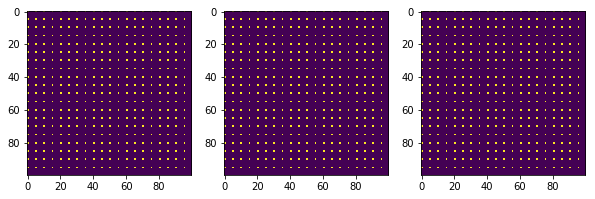

In [2]:
# In[2]:


size = 100
angle = 45

def synthetic_data(size,angle):
    xx = np.arange(0,size,5)
    yy = np.arange(0,size,5)
    x,y = np.meshgrid(xx,yy)

    im = np.zeros((100,100)).astype(int)

    im[x,y]=1
    h,w = x.shape

    nx = np.zeros((size,size))
    ny = np.zeros((size,size))

    teta = np.pi*angle/180
    nx[x,y]= np.cos(teta)
    ny[x,y]= np.sin(teta)
    n = np.stack([nx,ny])

    xks = np.array([xx,yy])
    
    print(xks.shape,h,w,n.shape)
    
    plot_synthetic(im,n)
    
    n = np.stack((nx,ny))
    
    return im,xks,n

def plot_synthetic(im,n):
    nx,ny = n
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(im)

    plt.subplot(1,3,2)
    plt.imshow(nx)

    plt.subplot(1,3,3)
    plt.imshow(ny)
    pass

im,xks,n = synthetic_data(size=100,angle=45)
n.shape

In [3]:
xks.shape

(2, 20)

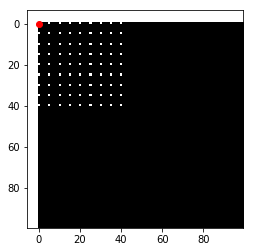

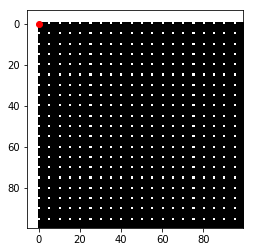

In [4]:
# In[3]:


ratio = (2,1) #(w,h)

def get_box(im,xks,n,lamb=10,ratio=(2,1),plot=False):
    N = xks.shape[1]
    idxs =  np.random.permutation(np.arange(N))
    idx = np.random.choice(idxs)
    xk = xks[:,idx]
 
    nx,ny = n[:,xk[1],xk[0]]

    wmax = xks[0].max()
    hmax = xks[1].max()  

    xmin = np.clip(xk[0]-ratio[0]*lamb,a_min=0,a_max=wmax)
    xmax = np.clip(xk[0]+ratio[0]*lamb,a_min=0,a_max=wmax)
    ymin = np.clip(xk[1]-ratio[1]*lamb,a_min=0,a_max=hmax)
    ymax = np.clip(xk[1]+ratio[1]*lamb,a_min=0,a_max=hmax)
    

    yyy,xxx = np.meshgrid(np.arange(xmin,xmax+1),np.arange(ymin,ymax+1))
    xks_box =  np.argwhere(im[xxx.astype(int),yyy.astype(int)]).T
    
    
    xks_box += np.array([int(xxx.min()),int(yyy.min())])[:,np.newaxis]
    
    mask = np.zeros_like(im)
    mask[xks_box[0,:],xks_box[1,:]]=1
    
    if plot:

        #plt.scatter(xks_box[1,:],xks_box[0,:],c='r')
        plt.imshow(mask,**{'cmap':'gray'})
        plt.scatter(xk[0],xk[1],c='r')
        plt.show()
        plt.imshow(im,**{'cmap':'gray'})
        plt.scatter(xk[0],xk[1],c='r')
        plt.show()
    
    return np.argwhere(mask).T,(xxx,yyy,xmin,xmax,ymin,ymax,wmax,hmax),(xk,nx,ny),mask

xks_box,grid_data,xc_data,mask = get_box(im,xks,n,lamb=40,ratio=(1,1),plot=True)

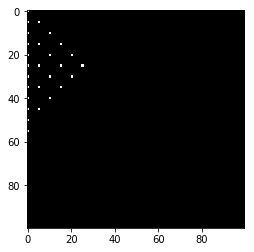

'\nxc_data - xc, nx, ny\nxks_box - kps 2xN\n'

In [5]:
# In[4]:

def rotate(im,grid_data,xc_data,ref=1,plot=False):
    
    xxx,yyy,xmin,xmax,ymin,ymax,wmax,hmax = grid_data
    xxx, yyy= np.meshgrid(np.arange(xmin,xmax,ref),np.arange(ymin,ymax,ref))
    
    xk,nx,ny = xc_data
    
    Rot = np.array([[nx,-ny],[ny,nx]])

    x_,y_ = Rot.dot(np.array((xxx.flatten()-xk[0],yyy.flatten()-xk[1])))
    
    x_ += xk[0]
    y_ += xk[1]
    x_ = x_.astype(int)
    y_ = y_.astype(int)
    #plt.scatter(x_,y_)
    
    remove = np.append(np.argwhere(x_>wmax),np.argwhere(y_>hmax))
    remove = np.append(remove,np.argwhere(x_<0))
    remove = np.append(remove,np.argwhere(y_<0))
    
    x_ = np.delete(x_,remove).astype(int)
    y_ = np.delete(y_,remove).astype(int)

    keep = np.argwhere(im[y_,x_])
    #plt.scatter(x_[keep],y_[keep])
    mask = np.zeros_like(im)
    
    mask[y_[keep],x_[keep]]=1
    
    if plot:
        #plt.imshow(im,**{'cmap':'gray'})
        #plt.scatter(y_[keep],x_[keep],c='r')
        plt.imshow(mask,**{'cmap':'gray'})
        plt.show()
        #np.squeeze(np.array([x_[keep],y_[keep]]))
    return np.argwhere(mask).T,mask

xks_box,mask = rotate(im,grid_data,xc_data,plot=True)

"""
xc_data - xc, nx, ny
xks_box - kps 2xN
"""

In [6]:
# In[9]:


class scope_selector:
    def __init__(self,im,xks,n,**box_params):
        self.nSamples=1
        self.im = im
        self.n = n
        self.xks = xks
        self.N = xks.shape[1]
        self.idxs = np.random.permutation(np.arange(self.N))
        self.kp = None
        self.minKps=20
        self.nkps = 0
        self.mask = None
        self.lamb=10
        self.ratio=(1,2)
        self.rotate=False
        self.minKps=5
        if isinstance(box_params,dict):
            for k,v in box_params.items():
                self.__dict__[k]=v
    
    def fit(self):
        lamb = self.lamb
        ratio = self.ratio
        nKps=0
        count=0
        while nKps<self.minKps:
            xks_box,grid_data,xc_data,mask = get_box(self.im,self.xks,self.n,lamb,ratio)
            if self.rotate: xks_box,mask = rotate(self.im,grid_data,xc_data)
            self.xc_data = xc_data
            nKps = xks_box.shape[1]
            count+=1
            if count>5:
                print("box is too small")
                break
        self.nKps = nKps
        self.mask = mask
        xk,nn = get_sample(nKps,xks_box,self.n,self.nSamples)
        
        return {'xks':xks_box,'xc_data':xc_data,'nKps':nKps,'sample_xk':xk,'sample_n':nn}
    
    def __iter__(self):
        self.kp = self.fit()
        return self
    
    def __next__(self):
        kps = self.fit()
        
        return kps


In [7]:
# In[10]:

def get_sample(nKps,xks,ns,nSamples):
    idxs = np.arange(nKps)
    xk = []
    n =[]
    for i in range(nSamples):
        idx = np.random.choice(idxs)
        xk.append(xks[:,idx])
        n.append(ns[:,xks[:,idx][0],xks[:,idx][1]])
    y,x = np.array(xk).T
    xk = np.array([x,y])
    n = np.array(n).T
    return xk,n


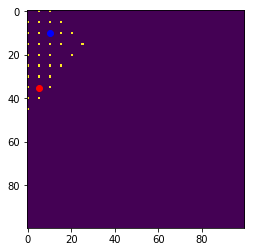

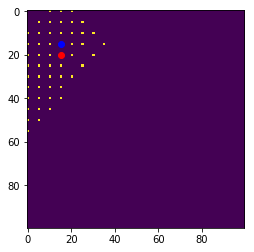

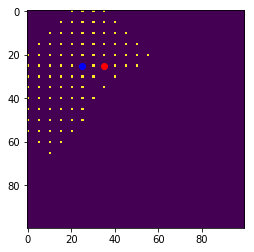

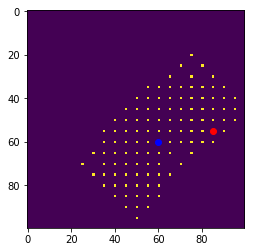

In [8]:
# In[12]:

box_params = {"ratio":(2,4),"lamb":10,"rotate":True,"minKps":5}
scope_iterator = scope_selector(im,xks,n,**box_params)
nSamples = 1
for i in range(4):
    out = next(scope_iterator)
    xc,nx,ny = out['xc_data']
    nKps = out['nKps']
    xk = out['sample_xk']
    nn = out['sample_n']    
    mask = scope_iterator.mask
    
    plt.scatter(xc[0],xc[1],c="b")
    plt.scatter(xk[0,:],xk[1,:],c="r")
    plt.imshow(mask)
    plt.show()
   


In [9]:
import pickle
f = open('data/coin_data/edgels.pickle','rb')
data = pickle.load(f)
f.close()

(2, 300, 300) (2, 3024)


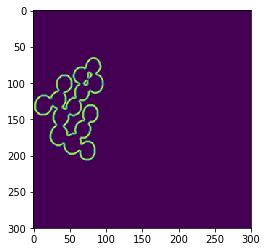

In [10]:
data.keys()
i = 11
y,x = np.argwhere(data['grads'][i]['S']).T
xks = np.array((x,y))
n = data['grads'][i]['n']
print(n.shape,xks.shape)
plt.imshow(data['grads'][i]['S'])
im = data['grads'][i]['S']

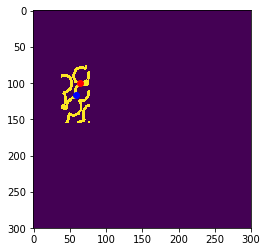

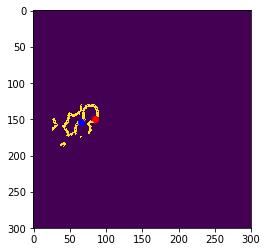

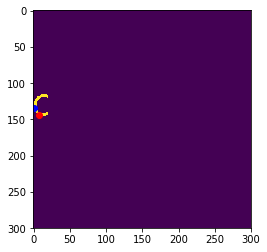

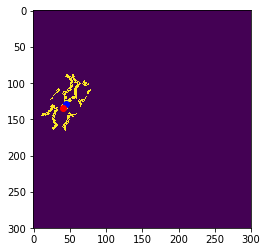

In [11]:
box_params = {"ratio":(2,4),"lamb":10,"rotate":True,"minKps":5}
scope_iterator = scope_selector(im,xks,n,**box_params)
nSamples = 1
for i in range(4):
    out = next(scope_iterator)
    xc,nx,ny = out['xc_data']
    nKps = out['nKps']
    xk = out['sample_xk']
    nn = out['sample_n']    
    mask = scope_iterator.mask
    
    plt.scatter(xc[0],xc[1],c="b")
    plt.scatter(xk[0,:],xk[1,:],c="r")
    plt.imshow(mask)
    plt.show()

In [12]:
with open('data/edgels_lines.pickle','rb') as f:
    data = pickle.load(f)
    f.close()

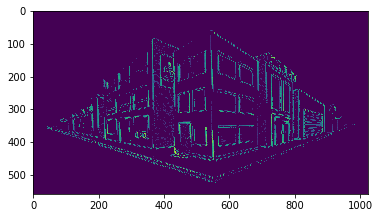

In [13]:
y,x = np.argwhere(data['S']).T
xks = np.array((x,y))
n = data['n']
n.shape,xks.shape
plt.imshow(data['S'])
im = data['S']

In [14]:
y.max(),x.max(),n.shape

(527, 984, (2, 559, 1024))

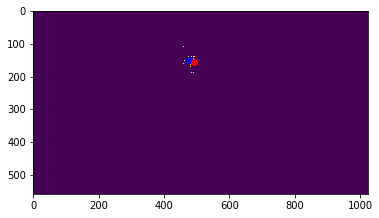

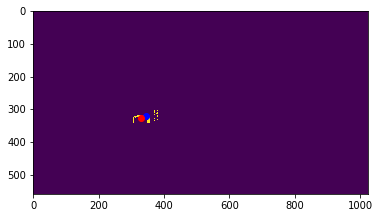

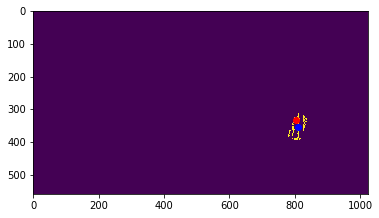

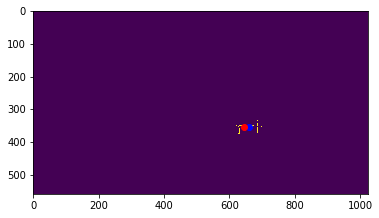

In [15]:
box_params = {"ratio":(2,4),"lamb":10,"rotate":True,"minKps":5}
scope_iterator = scope_selector(im,xks,n,**box_params)
nSamples = 1
for i in range(4):
    out = next(scope_iterator)
    xc,nx,ny = out['xc_data']
    nKps = out['nKps']
    xk = out['sample_xk']
    nn = out['sample_n']    
    mask = scope_iterator.mask
    
    plt.scatter(xc[0],xc[1],c="b")
    plt.scatter(xk[0,:],xk[1,:],c="r")
    plt.imshow(mask)
    plt.show()